In [98]:
# try to run code with tf 1.0

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [100]:
import numpy as np
# import tensorflow as tf
# import tensorflow.contrib.eager as tfe
import importlib

keras = tf.keras
# tf.enable_eager_execution()

import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "../src")

In [101]:
from euler import fwd_tlist, fwd_sde_tlist
importlib.reload(sys.modules['euler'])
import models as md
importlib.reload(sys.modules['models'])
import training as tr
importlib.reload(sys.modules['training'])
from utilities import rand_batch, tile_batch
importlib.reload(sys.modules['utilities'])

<module 'utilities' from '../src/utilities.py'>

In [102]:
print(md.oscillator_NNcontrol.__doc__)

AttributeError: module 'models' has no attribute 'oscillator_NNcontrol'

# Perturbed oscillator as neural SDE

In [103]:
time_steps = 1000
t_free = np.linspace(0, 100, time_steps)
y0_free = tf.cast([[5.], [5.]], tf.float32)

free_trajectory = fwd_tlist(md.Oscillator(), y0_free, t_free, 1e-2)
free_trajectory = np.concatenate(free_trajectory[:,0,0])
free_trajectory.shape

plt.plot(t_free,free_trajectory)
plt.show()

OperatorNotAllowedInGraphError: using a `tf.Tensor` as a Python `bool` is not allowed in Graph execution. Use Eager execution or decorate this function with @tf.function.

# Oscillator with pre-defined linear controller

In [96]:
# Oscillator with controller defined by neural network
class ControlledOscillator(tf.keras.Model):
    
    def __init__(self):
        super(ControlledOscillator, self).__init__()
        self.A = tf.cast([[0, 1],[-1, -0.1]],tf.float32)
        self.k = tf.cast([[0, 0],[-23, -10]],tf.float32)
        
    def forward(self, t, y):
        free = tf.matmul(self.A, y)
        con = tf.matmul(self.k, y)
        dy = tf.add(free, con)
        return dy

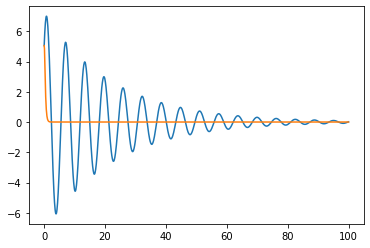

In [115]:
time_steps = 1000
t_grid = np.linspace(0, 100, time_steps)
y0 = tf.cast([[5.], [5.]], tf.float32)

trajectory = fwd_tlist(ControlledOscillator(), y0, t_grid, 1e-2)
y = np.concatenate(trajectory[:,0,0])
ydot = np.concatenate(trajectory[:,0,1])
trajectory.shape

# plt.plot(t_grid,free_trajectory, t_grid,y)
plt.plot(t_free,free_trajectory, t_grid,y)
plt.show()

# Oscillator with NN controller

This basically amounts to learning the matrix k (or a better version thereof) defined above in odeModel_oscillator_control.

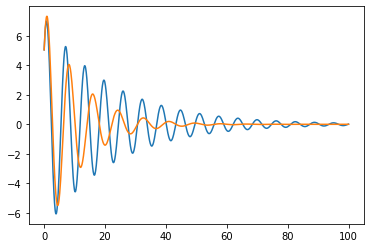

In [119]:
time_steps = 1000
t_grid = np.linspace(0, 100, time_steps)
y0 = tf.cast([[5.], [5.]],tf.float32)

free_trajectory = fwd_tlist(md.Oscillator(), y0, t_grid, 1e-2)
free_trajectory = np.concatenate(free_trajectory[:,0,0])

# Run forward evaluation
trajectory = fwd_tlist(md.OscillatorNNControl(), y0, t_grid, 1e-2)
trajectory = np.concatenate(trajectory[:,0,0])

plt.plot(t_grid,free_trajectory, t_grid,trajectory)

# Train

In [63]:
def train_ode(model, batch_size, niters, test_freq, t_grid, free_trajectory):
    y0 = tf.cast([[5.], [5.]],tf.float32)

    optimizer = tf.train.MomentumOptimizer(learning_rate=1e-5, momentum=0.95)
    
    loss_history = []    

    for step in range(niters+1):
    
        batch_y0 = rand_batch(batch_size, val=15.) # Random
#         batch_y0 = tile_batch(batch_size, y0) # Fixed

        loss = tr.gradient_update(model, fwd_tlist, optimizer, batch_y0, t_grid)
        # loss = compute_gradients_and_update_path(model, fwd_tlist, optimizer, batch_y0)    
        loss_history.append(loss.numpy())

        if step % test_freq == 0:        
            trajectory = euler_self_tlist(model, y0, t_grid, 1e-2)        
            print(loss)

            trajectory = np.concatenate(trajectory[:,0,0])
            plt.plot(t_grid,free_trajectory, t_grid,trajectory)
            plt.legend( ('free oscillator', 'controlled oscillator/system'))
            plt.show()

    return loss_history

In [112]:
def train_sde(model, batch_size, niters, test_freq, t_grid, free_trajectory):
    y0 = tf.cast([[5.], [5.]],tf.float32)

    optimizer = tf.train.MomentumOptimizer(learning_rate=1e-5, momentum=0.95)
    
    loss_history = []    

    for step in range(niters+1):
    
        batch_y0 = rand_batch(batch_size, val=15.) # Random
#         batch_y0 = tile_batch(batch_size, y0) # Fixed

        loss = tr.gradient_update(model, fwd_sde_tlist, optimizer, batch_y0, t_grid)
        # loss = compute_gradients_and_update_path(model, euler_sde, optimizer, batch_y0)    
        loss_history.append(loss.numpy())

        if step % test_freq == 0:        
            trajectory = fwd_sde_tlist(model, y0, t_grid, 1e-2)        
            print(loss)

            trajectory = np.concatenate(trajectory[:,0,0])
            plt.plot(t_grid,free_trajectory, t_grid,trajectory)
            plt.legend( ('free oscillator', 'controlled oscillator/system'))
            plt.show()

    plt.plot(loss_history)
    plt.yscale("log")
    return loss_history

# Linear NN ode

In [44]:
# Set up parameters
time_steps = 50
t_grid = np.linspace(0, 50, time_steps)

# Free system for comparison
free_trajectory = fwd_tlist(md.Oscillator(), y0, t_grid, 1e-2)
free_trajectory = np.concatenate(free_trajectory[:,0,0])

# Initialise new instance of the model
model = md.OscillatorLinearControl()

batch_size = 10
niters = 100
test_freq = 200

tf.Tensor([50.629654], shape=(1,), dtype=float32)


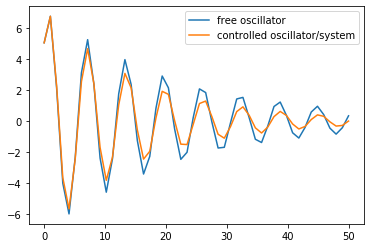

In [45]:
loss_history = train_ode(model, batch_size, niters, test_freq, t_grid, free_trajectory)

In [46]:
model.get_weights()

[array([[ 0.09695923],
        [-1.0036666 ]], dtype=float32), array([0.00043653], dtype=float32)]

# Non-linear NN ode

In [47]:
# Set up parameters
time_steps = 50
t_grid = np.linspace(0, 50, time_steps)

# Free system for comparison
free_trajectory = fwd_tlist(md.Oscillator(), y0, t_grid, 1e-2)
free_trajectory = np.concatenate(free_trajectory[:,0,0])

# Initialise new instance of the model
model = md.OscillatorNNControl()

batch_size = 10
niters = 100
test_freq = 20

tf.Tensor([13.745972], shape=(1,), dtype=float32)


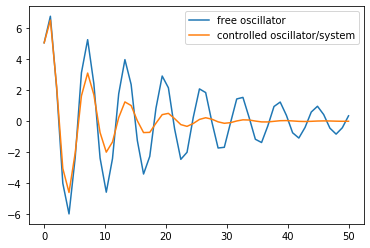

tf.Tensor([7.3922334], shape=(1,), dtype=float32)


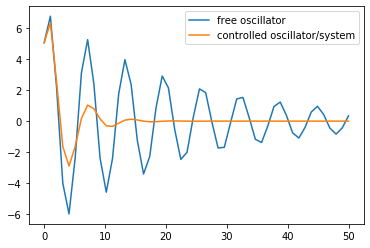

tf.Tensor([3.7896066], shape=(1,), dtype=float32)


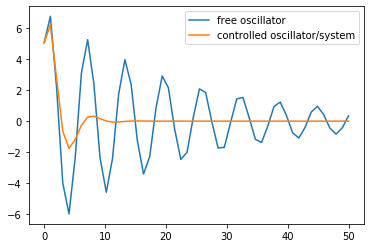

tf.Tensor([4.3450584], shape=(1,), dtype=float32)


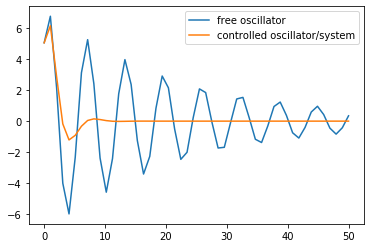

tf.Tensor([3.7791042], shape=(1,), dtype=float32)


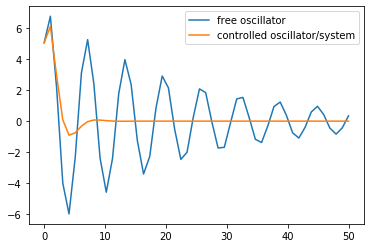

tf.Tensor([3.76116], shape=(1,), dtype=float32)


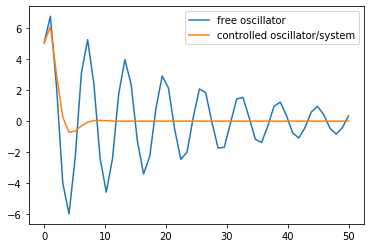

In [48]:
loss_history = train_ode(model, batch_size, niters, test_freq, t_grid, free_trajectory)

# Linear NN SDE

In [99]:
# Set up parameters
time_steps = 50
t_grid = np.linspace(0, 50, time_steps)

# Free system for comparison
free_trajectory = fwd_tlist(md.Oscillator(), y0, t_grid, 1e-2)
free_trajectory = np.concatenate(free_trajectory[:,0,0])

# Initialise new instance of the model
# model = md.OscillatorLinearControlSDE()
model = md.OscillatorLinearControl()

batch_size = 50
niters = 20
test_freq = 20

tf.Tensor([69.43435], shape=(1,), dtype=float32)


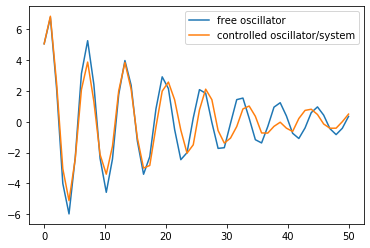

tf.Tensor([3.3444138], shape=(1,), dtype=float32)


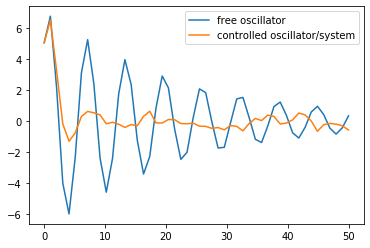

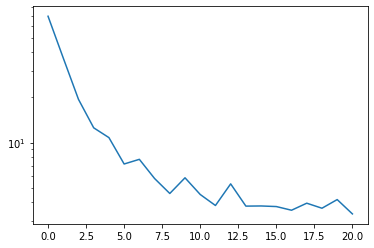

In [100]:
loss_history = train_sde(model, batch_size, niters, test_freq, t_grid, free_trajectory)

# Non-linear NN SDE

In [68]:
# Set up parameters
time_steps = 50
t_grid = np.linspace(0, 50, time_steps)

# Free system for comparison
free_trajectory = fwd_tlist(md.Oscillator(), y0, t_grid, 1e-2)
free_trajectory = np.concatenate(free_trajectory[:,0,0])

# Initialise new instance of the model
model = md.OscillatorNNControl()

batch_size = 50
niters = 20
test_freq = 20

tf.Tensor([10.412766], shape=(1,), dtype=float32)


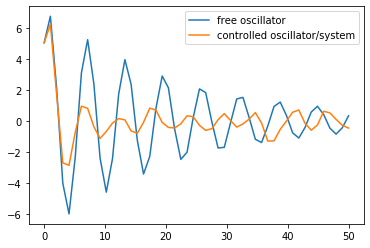

tf.Tensor([6.359476], shape=(1,), dtype=float32)


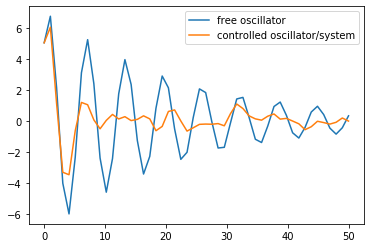

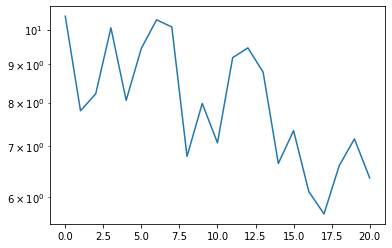

In [69]:
loss_history = train_sde(model, batch_size, niters, test_freq, t_grid, free_trajectory)